# Feature Extraction

Multiple features extracted. 

- The Attach, Release and peak fuatures are derived from [Daisuke Niizumi's](https://www.kaggle.com/daisukelab) method. 
  Different predictors are created. For example, shape and width of spikes spectrum, number of zero-crossings, number of peaks in spectrum, etc
  
  
- Second method is a MFCC/ mel spectrogram. 

In [41]:
# import all libs
import os
from collections import Counter
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

import librosa
from scipy.io import wavfile

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn import preprocessing

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn import manifold, datasets
from sklearn.preprocessing import scale

In [2]:
os.chdir('../')

In [3]:
path = os.getcwd()

In [4]:
# create different features
# running mean of a signal
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    run_mean = (cumsum[N:] - cumsum[:-N]) / float(N)
    return run_mean

def get_width(w):
    if np.sum(w) == 0:
        return [0,0,0]
    else:
        z = np.diff(np.where(np.insert(np.append(w,0),0,0)==0))-1
        z = z[z>0]
    return [np.log(1+np.mean(z)),np.log(1+np.std(z)),np.log(1+np.max(z)),len(z)]

def get_spectra_win(y, L, N):
    dft = np.fft.fft(y)
    fl = np.abs(dft)
    xf = np.arange(0.0, N/L, 1/L)
    return (xf,fl)

# get mean and standard spectrum
def get_spectra(signal, fs, M = 1000, sM = 500):

    N = signal.shape[0]
    ind = np.arange(100, N, M)

    spectra = []
    meanspectrum = np.repeat(0,M)

    for k in range(1,len(ind)):
        n1 = ind[k-1]
        n2 = ind[k]
        y = signal[n1:n2]
        L = (n2-n1)/fs
        N = n2-n1
        (xq, fq) = get_spectra_win(y, L, N)
        spectra.append(fq)

    spectra = pd.DataFrame(spectra)
    meanspectrum = spectra.apply(lambda x: np.log(1+np.mean(x)), axis=0)
    stdspectrum = spectra.apply(lambda x: np.log(1+np.std(x)), axis=0)
    
    meanspectrum = meanspectrum[0:sM]
    stdspectrum = stdspectrum[0:sM]
    
    return (meanspectrum, stdspectrum) 

In [21]:
dir_path = 'data/audio_train/'
# get all wav files 
score_filelist = [str(x) for x in os.listdir(dir_path)]
labelnames = np.repeat('unlabeled', len(score_filelist))
le = preprocessing.LabelEncoder()
le.fit(labelnames)
files_labels = zip(score_filelist, labelnames)

In [51]:
# map filenames with the labels
trainnames = pd.read_csv(path + '/data' + '/train.csv')
labelnames = list(trainnames['label'].unique())
le = preprocessing.LabelEncoder()
le.fit(labelnames)
files_labels = zip(trainnames['fname'].values, trainnames['label'].values)

In [99]:
df_m = []
df_sd = []
df_sig = []


for filename, labelname in files_labels:
    label = le.transform([labelname])
    fname = dir_path + filename
    fs, rawsignal = wavfile.read(fname)
    
    # normalize signals based on bit rate
    nb_bits = 16 # since all wav are 16bits
    max_nb_bit = float(2 ** (nb_bits - 1))
    rawsignal = rawsignal / max_nb_bit
    
    
    # get signal features
    # create lists
    rawsignal_sq = rawsignal*rawsignal
    silenced = []
    sound = []
    attack = []
    
    # compute running mean and get the silenced signal
    for wd in [2000, 10000]:
        rawsignal_sq_rm = running_mean(rawsignal_sq, wd)
        w1 = 1*(rawsignal_sq_rm<0.01*np.max(rawsignal_sq_rm))
        silenced = silenced + get_width(w1)
        w2 = 1*(rawsignal_sq_rm<0.05*np.max(rawsignal_sq_rm))
        silenced = silenced + get_width(w2)
        w3 = 1*(rawsignal_sq_rm>0.05*np.max(rawsignal_sq_rm))
        sound = sound + get_width(w3)
        w4 = 1*(rawsignal_sq_rm>0.25*np.max(rawsignal_sq_rm))
        sound = sound + get_width(w4)
        
        time_to_attack = np.min(np.where(rawsignal_sq_rm>0.99*np.max(rawsignal_sq_rm)))
        time_rel = np.where(rawsignal_sq_rm<0.2*np.max(rawsignal_sq_rm))[0]
        if (time_rel.size == 0):
            time_to_relax = len(rawsignal_sq_rm)
        elif (time_rel[time_rel>time_to_attack].size==0):
            time_to_relax = len(rawsignal_sq_rm)
        else:
            time_to_relax = np.min(time_rel[time_rel>time_to_attack])
        attack.append(np.log(1+time_to_attack))
        attack.append(np.log(1+time_to_relax))
        
    lr = len(rawsignal)
    zerocross_tot = np.log(1+np.sum(np.array(rawsignal[0:(lr-1)])*np.array(rawsignal[1:lr])<=0))
    zerocross_prop = np.sum(np.array(rawsignal[0:(lr-1)])*np.array(rawsignal[1:lr])<=0)/lr
    
    # collect all features
    df_sig.append(sound+silenced+attack+[zerocross_tot,zerocross_prop])

    # get specto params and add to respective df's
    (m, sd) = get_spectra(rawsignal, fs, 2000, 1000)
    df_m.append(m)
    df_sd.append(sd)

In [108]:
# get length of features
len(df_m), len(df_sd), len(df_sig)

(9473, 9473, 9473)

In [110]:
# with every id having 1000 feature points
len(df_m[9000]), len(df_sd[9000]), len(df_sig[9000])

(1000, 1000, 38)

In [134]:
rnd_ = random.choices(range(1, len(df_m)), k = 2)

Text(0.5, 0.98, 'Features from two randomly chosen signal')

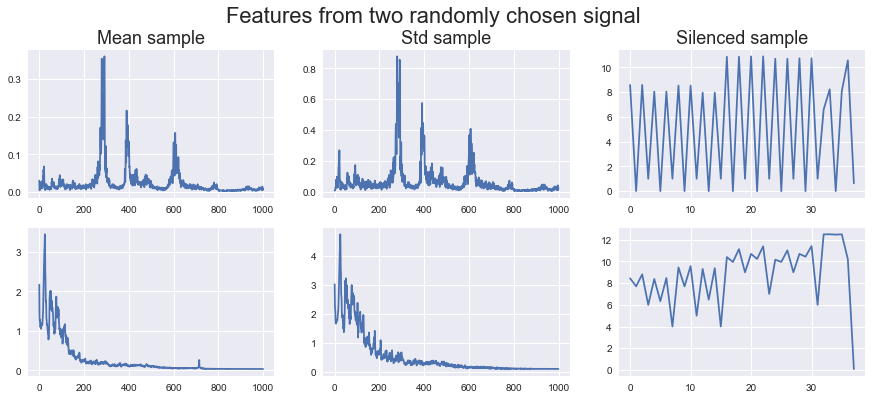

In [146]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6))
axes[0, 0].plot(df_m[rnd_[0]])
axes[0, 0].set_title('Mean sample', fontsize= 18)
axes[0, 1].plot(df_sd[rnd_[0]])
axes[0, 1].set_title('Std sample', fontsize= 18)
axes[0, 2].plot(df_sig[rnd_[0]])
axes[0, 2].set_title('Silenced sample', fontsize= 18)
axes[1, 0].plot(df_m[rnd_[1]])
axes[1, 1].plot(df_sd[rnd_[1]])
axes[1, 2].plot(df_sig[rnd_[1]])
fig.suptitle('Features from two randomly chosen signal', fontsize = 22)

## Plots of some rawsignals and extracted features

In [92]:
filename, labelname

('fff81f55.wav', 'Cough')

Text(0.5, 1.0, 'Signal squared')

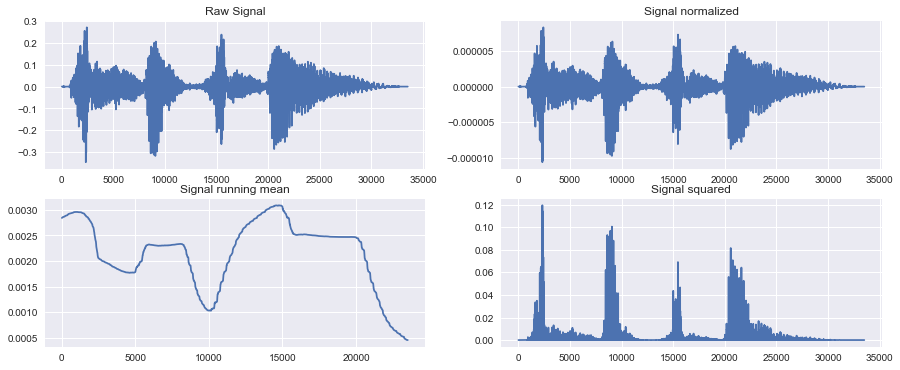

In [166]:
# visulaizing the signal processed for this above sample.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
axes[0, 0].plot(rawsignal)
axes[0, 0].set_title('Raw Signal')
axes[0, 1].plot(rawsignal/max_nb_bit)
axes[0, 1].set_title('Signal normalized')
axes[1, 0].plot(rawsignal_sq_rm)
axes[1, 0].set_title('Signal running mean')
axes[1, 1].plot(rawsignal_sq)
axes[1, 1].set_title('Signal squared')

## Mel Frequency Coefficients (MFCC) features


The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. In MIR, it is often used to describe timbre.

In [52]:
# store all files_names in a list
files_unziped = list(files_labels)

In [56]:
filename, labelname = random.choice(files_unziped)
print(filename, labelname)

label = le.transform([labelname])
fname = dir_path + filename
fs, rawsignal = wavfile.read(fname)
    
# normalize signals based on bit rate
nb_bits = 16 # since all wav are 16bits
max_nb_bit = float(2 ** (nb_bits - 1))
rawsignal = rawsignal / max_nb_bit

7e75301b.wav Applause


In [57]:
# try for a single signal
df_mfcc = []

mfcc_feat = librosa.feature.mfcc(rawsignal, sr = fs, n_mfcc=40)
mfcc_feat = pd.DataFrame(np.transpose(mfcc_feat))       
        
mfcc_mean = mfcc_feat.apply(lambda x: np.mean(x), axis=0)
mfcc_sd = mfcc_feat.apply(lambda x: np.std(x), axis=0)
mfcc_max = mfcc_feat.apply(lambda x: np.max(x), axis=0)
mfcc_med = mfcc_feat.apply(lambda x: np.median(x), axis=0)        
mfcc_res = np.array(list(mfcc_mean)+list(mfcc_sd)+list(mfcc_max)+list(mfcc_med)+[np.log(1+len(rawsignal))])
df_mfcc.append(mfcc_res)

Text(0.5, 1.0, 'MFCC feature from: Applause')

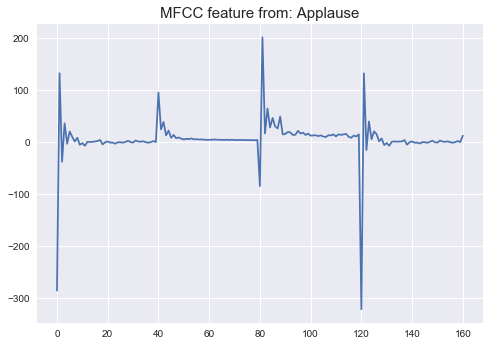

In [72]:
plt.plot(df_mfcc[0])
plt.title('MFCC feature from: {}' .format(labelname), fontsize=15)